# Overview
The purpose of this excersize is to use the petfinder data we collected to see if there is a correlation between ownerless dogs and poverty, housing, etc.

In [121]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

# Load data

In [122]:
#specify the folders you store all your data in
pf_data_folder = 'petfinder_data'
census_data_folder = 'census_data'

## Retrieve the state-by-state petfinder data

This data was generated using **FETCH_PetFinder_data.ipynb** followed by **stats_per_state.ipynb**

In [132]:
#for each time you retreived petfinder data, provide the file name of the state-by-state analysis output. Store the file names as values and the date the data was retrieved as the key. 
statewise_analysis_files = {'2025-03-17': '2025-03-17_stats_per_state_results.csv', 
                            '2025-04-03': '2025-04-03_stats_per_state_results.csv'}



#load each dataframe into a dictionary
dogdfs = {}

for date, file in statewise_analysis_files.items():
    #load the data into the dictionary...
    df = pd.read_csv(f'{pf_data_folder}/{file}')
    dogdfs[date] = df
    

## Retrieve US Census data

### Prepare the 2024 population estimates for each state using data from the US Census website
The most recent population estimates (2024) are not available through the API and cloudforce prevents python from reading it directly from the ftp2 site. Therefore, you will have to navigate to the below site in your browser and manually download it into your census data folder.

<https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/state/totals/NST-EST2024-ALLDATA.csv>


In [125]:
#the most recent population estimate data is not available through the API and cloudforce prevents python from reading it directly from the ftp2 site so you will have to navigate to the below site in your browser and manually download it
#https://www2.census.gov/programs-surveys/popest/datasets/2020-2024/state/totals/NST-EST2024-ALLDATA.csv
pop_data = pd.read_csv(f'{census_data_folder}/NST-EST2024-ALLDATA.csv')
pop_data = pop_data[['REGION', 'DIVISION', 'STATE', 'NAME', 'POPESTIMATE2024']]



Using the first few rows in the census data, create a dictionary matching regions IDs to their names

In [126]:
regions = pop_data.copy()

#fetch just the rows for the 9 regions
regions['REGION'] = pd.to_numeric(regions['REGION'], errors='coerce')
regions['DIVISION'] = pd.to_numeric(regions['DIVISION'], errors='coerce')
regions.dropna(inplace=True)
regions = regions.astype({'REGION': int, 'DIVISION': int})
regions = regions.query('(DIVISION > 0) & (STATE == 0)')

#create dictionary
region_dict = regions.set_index('DIVISION')['NAME'].to_dict()

### Retrieve the calculated economic/household data you generated from the 2023 ACS 1-year data
This data was generated using **census_ACS_analysis.ipynb**

In [127]:
acs_data = pd.read_csv(f'{census_data_folder}/2023_ACS_calculated_data.csv')

### Create a column containing the state abbreviations in each census dataset

The code in this chunk was taken directly from a Medium article by Jason C. (@jason_the_data_scientist)

In [128]:
#List of states
state2abbrev = {
    'Alaska': 'AK',
    'Alabama': 'AL',
    'Arkansas': 'AR',
    'Arizona': 'AZ',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'District of Columbia': 'DC',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Iowa': 'IA',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Massachusetts': 'MA',
    'Maryland': 'MD',
    'Maine': 'ME',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Missouri': 'MO',
    'Mississippi': 'MS',
    'Montana': 'MT',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Nebraska': 'NE',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'Nevada': 'NV',
    'New York': 'NY',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Virginia': 'VA',
    'Vermont': 'VT',
    'Washington': 'WA',
    'Wisconsin': 'WI',
    'West Virginia': 'WV',
    'Wyoming': 'WY',
    'Puerto Rico': 'PR',
    'Virigin Islands': 'VI'
}


pop_data['Abbr'] = pop_data['NAME'].str.strip().replace(state2abbrev)
acs_data['Abbr'] = acs_data['NAME'].str.strip().replace(state2abbrev)

# Analysis

## Look for correlation


For each df of petfinder results...
1) Calculate the number of dogs per 100000 people based on 2024 estimated population
2) Combine that data with the ACS data

Then combine the results into one df

In [129]:
state_stat_dfs = {}

for date, df in dogdfs.items():
    #merge the two datasets
    merged = pd.merge(df, pop_data, how='inner', left_on='state', right_on='Abbr')
    
    #keep only the columns we care about
    merged = merged[['state', 'count', 'DIVISION', 'POPESTIMATE2024']]
    
    #calculate dogs per capita
    merged['dogs_per_capita'] = merged['count'].div(merged['POPESTIMATE2024'], axis=0)*100000

    #add economic/household data generated from ACS 1yr dataset
    state_stats = pd.merge(merged, acs_data, how='inner', left_on='state', right_on='Abbr')
    state_stats.drop(columns=['NAME','Abbr'], inplace=True)

    #add the date so we can differentiate between the two petfinder datasets (if we want to)
    state_stats['DATASET'] = date

    #now save the resulting df in the dictionary we created
    state_stat_dfs[date] = state_stats
    
all_data = pd.concat(state_stat_dfs.values(), ignore_index=True)

Determine if poverty correlates with the relative number of dogs on petfinder

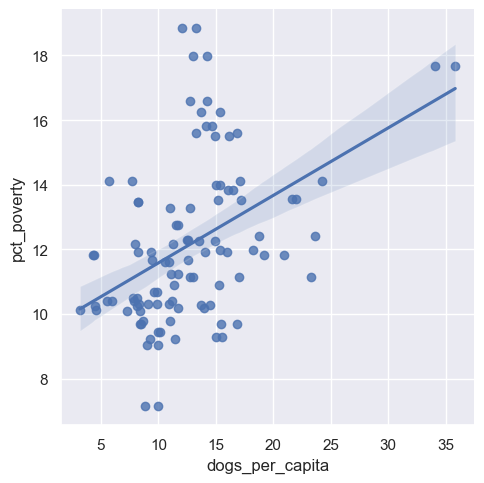

In [130]:
sns.lmplot(x='dogs_per_capita', y='pct_poverty', data=all_data);

No apparent correlation, but visualize the regions on a scatter plot anyway

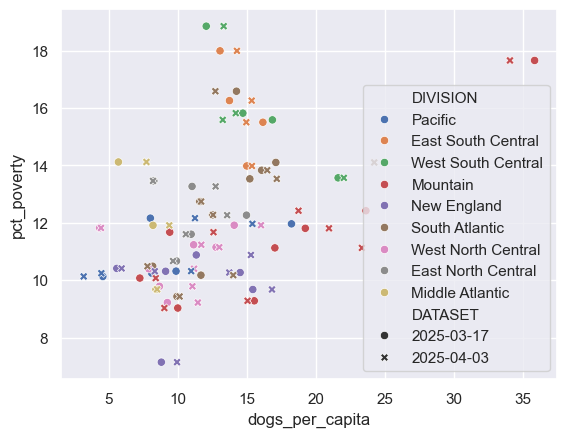

In [131]:
df = all_data.astype({'DIVISION':'int'})
df.replace({'DIVISION': region_dict}, inplace=True)
sns.scatterplot(x='dogs_per_capita', y='pct_poverty', data=df, hue='DIVISION', style='DATASET');